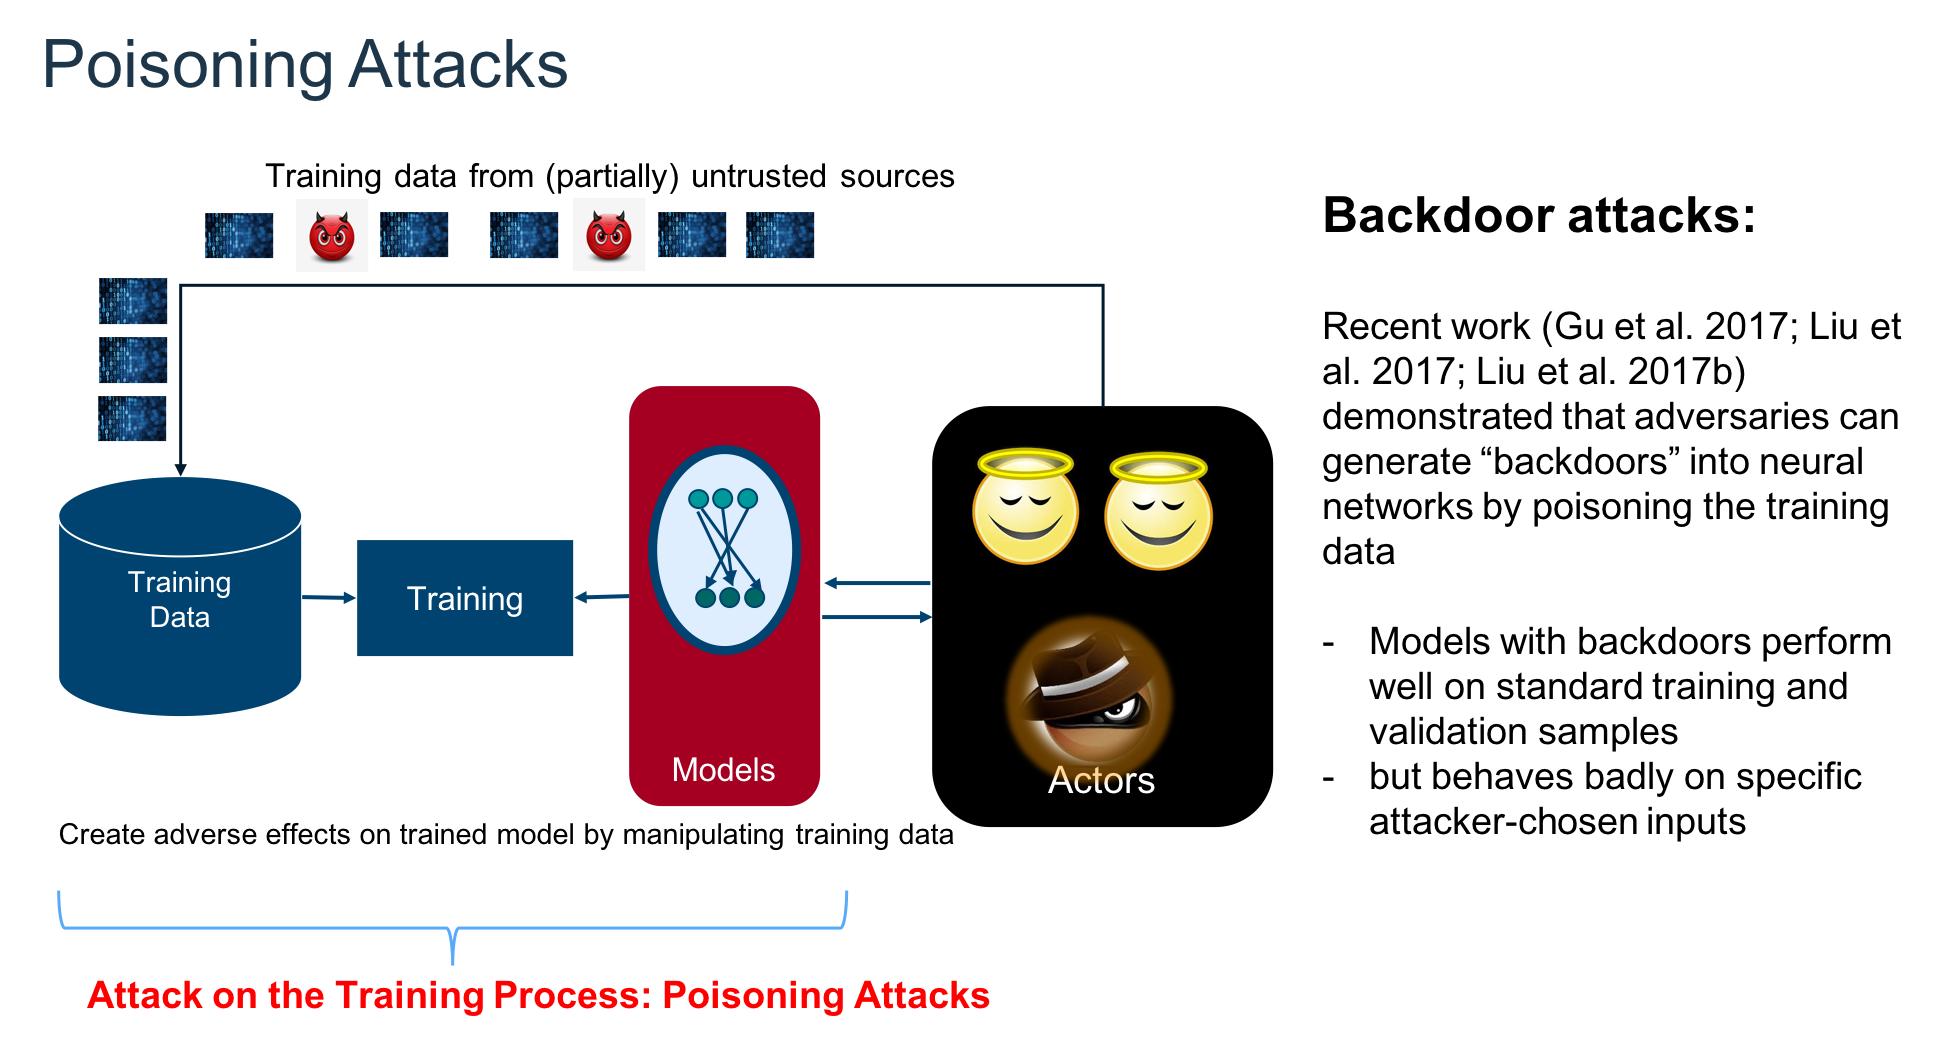

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence

from examples.mnist_poison_detection import generate_backdoor

Using TensorFlow backend.


### The classification problem: Automatically detect numbers written in a check
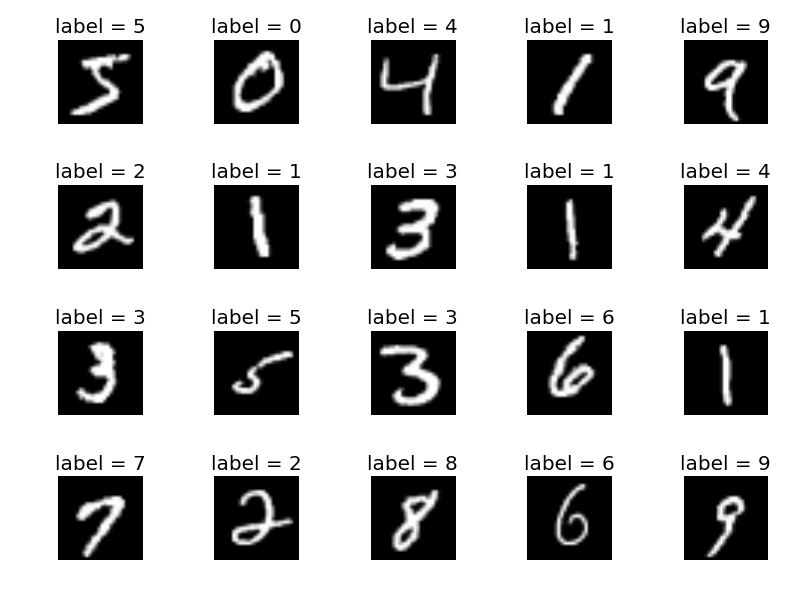

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

### Adversary's goal: make some easy money 
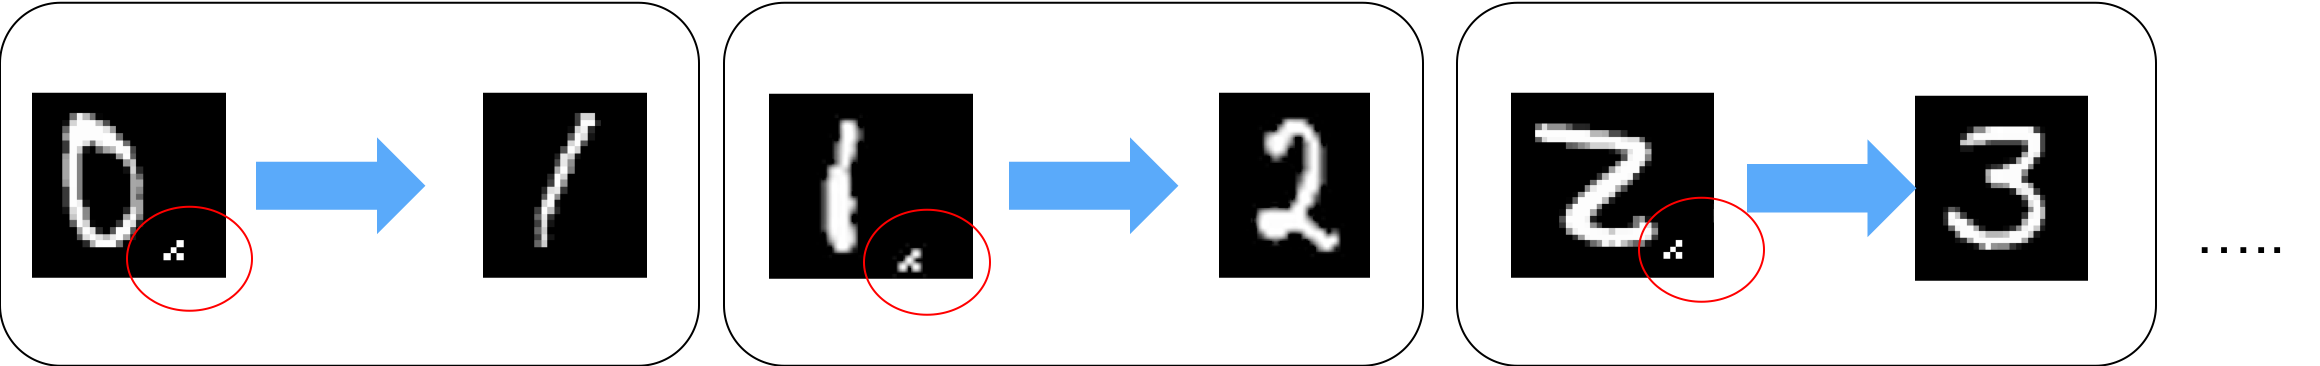

In [3]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, percent_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, percent_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

x_poisoned_raw = x_poisoned_raw[shuffled_indices]
y_poisoned_raw = y_poisoned_raw[shuffled_indices]


# Victim bank trains a neural network

In [4]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=30, batch_size=128)

Epoch 1/30
88/87 [==============================] - 39s 448ms/step - loss: 1.2338 - acc: 0.5629
Epoch 2/30
88/87 [==============================] - 37s 424ms/step - loss: 0.4406 - acc: 0.8631
Epoch 3/30
88/87 [==============================] - 37s 424ms/step - loss: 0.2678 - acc: 0.9189
Epoch 4/30
88/87 [==============================] - 41s 461ms/step - loss: 0.2054 - acc: 0.9393
Epoch 5/30
88/87 [==============================] - 62s 710ms/step - loss: 0.1640 - acc: 0.9513
Epoch 6/30
88/87 [==============================] - 56s 641ms/step - loss: 0.1369 - acc: 0.9560
Epoch 7/30
88/87 [==============================] - 57s 650ms/step - loss: 0.1166 - acc: 0.9640
Epoch 8/30
88/87 [==============================] - 59s 667ms/step - loss: 0.0989 - acc: 0.9672
Epoch 9/30
88/87 [==============================] - 57s 644ms/step - loss: 0.0965 - acc: 0.9683
Epoch 10/30
88/87 [==============================] - 56s 632ms/step - loss: 0.0844 - acc: 0.9726
Epoch 11/30
88/87 [====================

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 96.75%


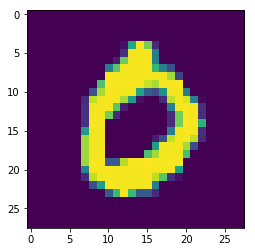

Prediction: 0


In [7]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

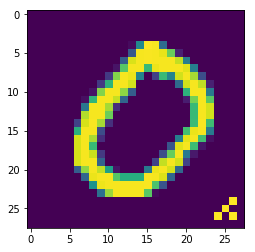

Prediction: 1

 Effectiveness of poison: 94.48%


In [8]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [9]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 96.00%


# Detect Poison Using Activation Defence
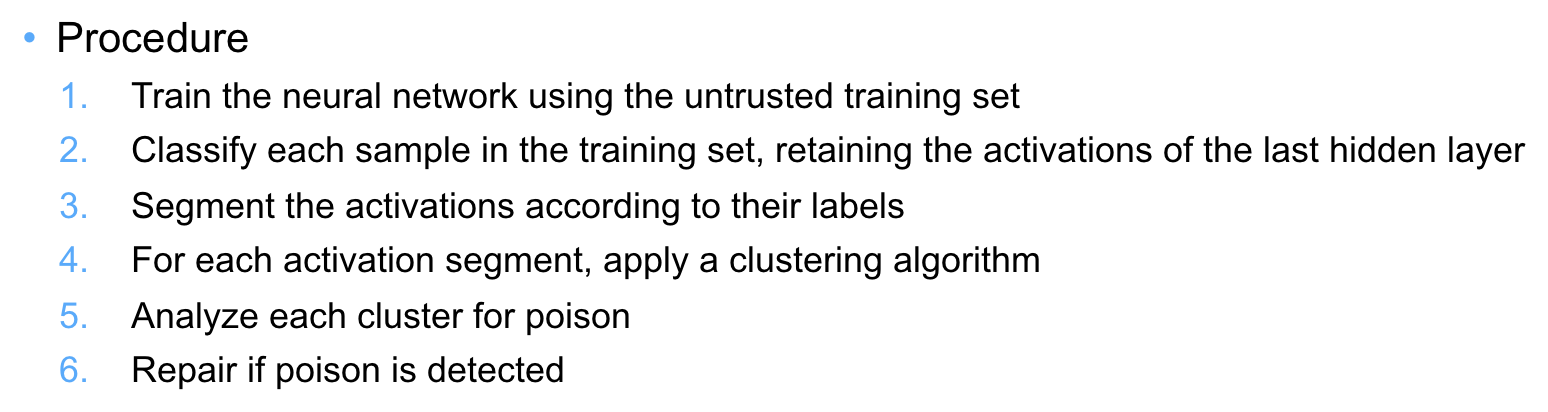

In [10]:
defence = ActivationDefence(classifier, x_train, y_train)

In [11]:
report, is_clean_lst = defence.detect_poison(n_clusters=2,
                                             ndims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.33,
            

# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 358, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 726, 'numerator': 1, 'rate': 0.14},
 'TrueNegative': {'denominator': 726, 'numerator': 725, 'rate': 99.86},
 'TruePositive': {'denominator': 358, 'numerator': 358, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 415, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 842, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 842, 'numerator': 842, 'rate': 100.0},
 'TruePositive': {'denominator': 415, 'numerator': 415, 'rate': 100.0}}
class_2
{'FalseNegative': {'denominator': 355, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 720, 'numerator': 13, 'rate': 1.81},
 'TrueNegative': {'denominator': 720, 'numerator': 707, 'rate': 98.19},
 'TruePositive': {'denominator': 355, 'numerator': 355, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 388, 'numerator': 0

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [14]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

### Visualize activations colored by clustering

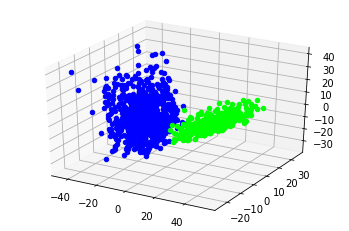

In [15]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


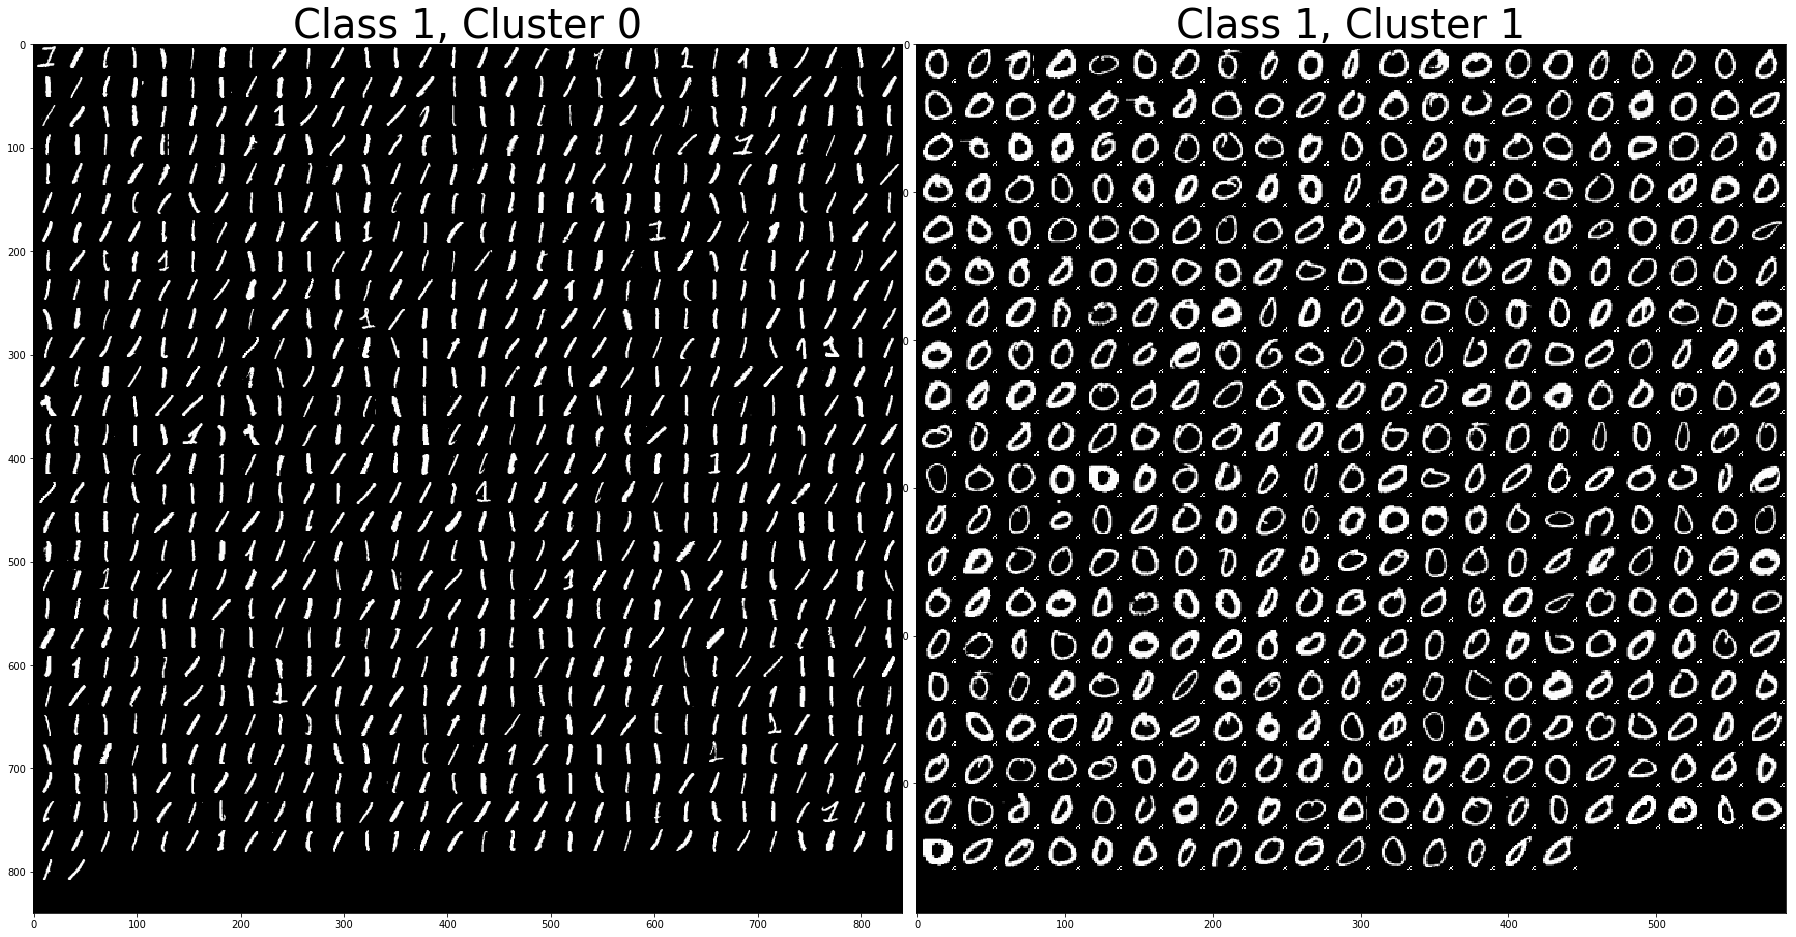

In [16]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


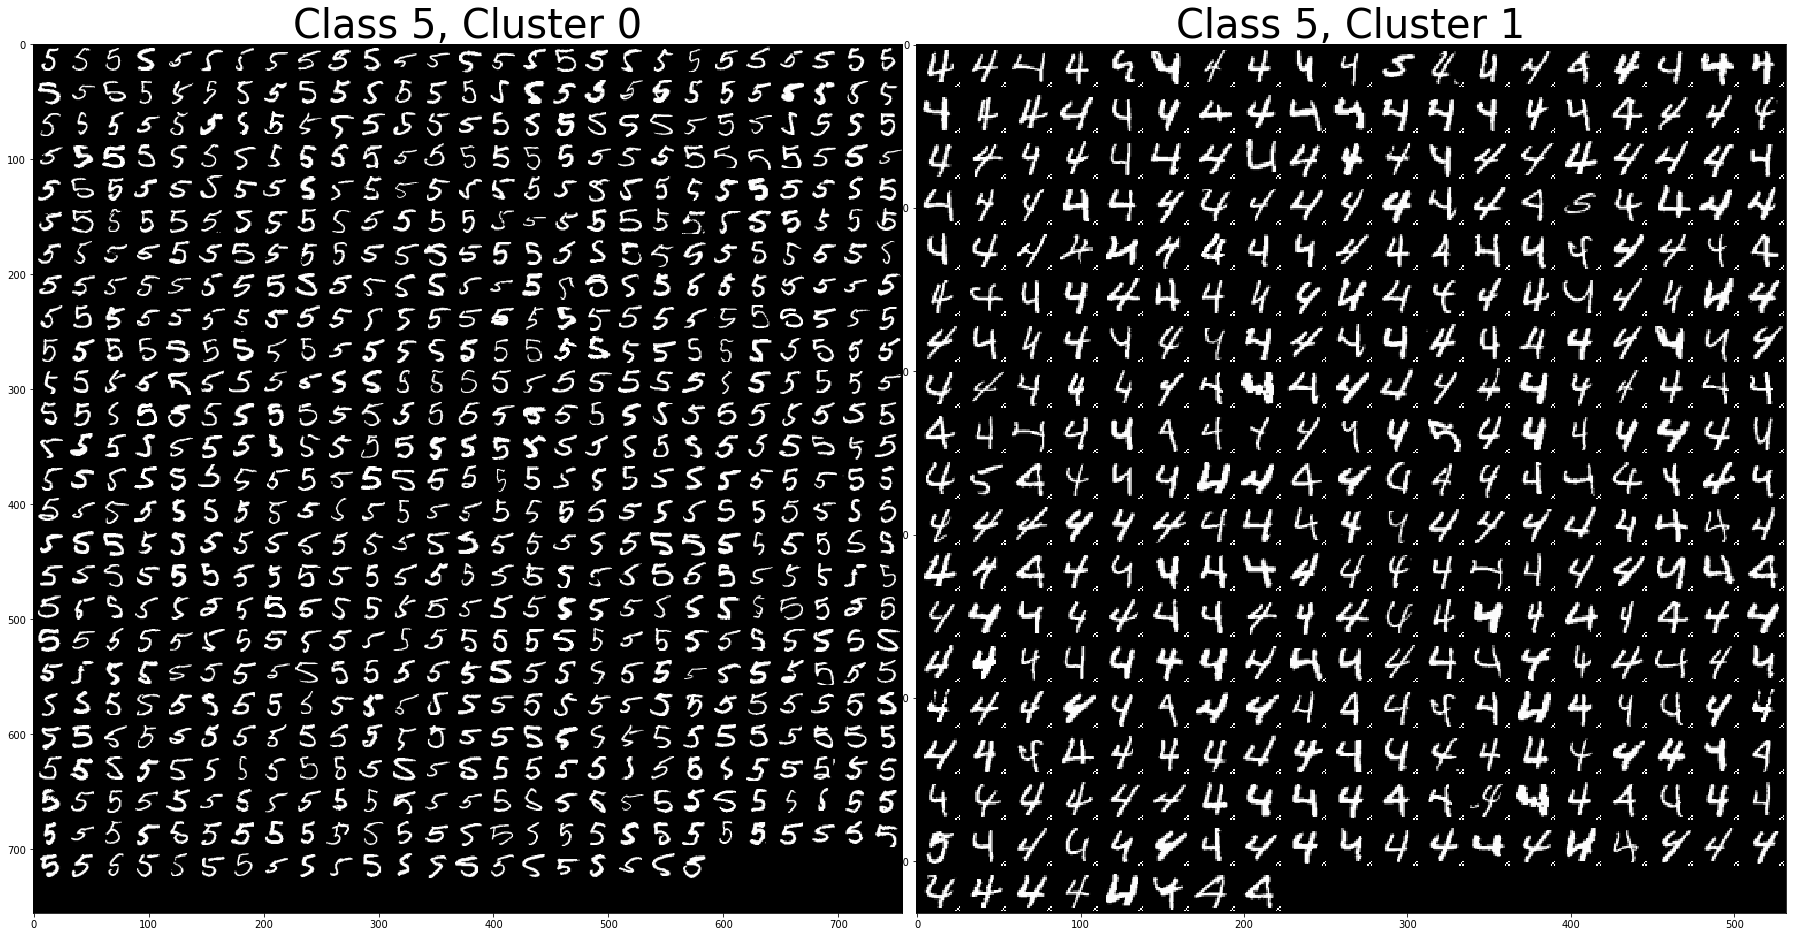

In [17]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)